In [1]:
import os
import json
import pandas as pd
import geopandas as gpd

import matplotlib.pyplot as plt

In [2]:
%matplotlib notebook

In [3]:
filepath = os.path.join("data", "processed", "buildings.gpkg")
gdf = gpd.read_file(filepath, driver="GPKG")
gdf.head(2)

ID_bat  ID_Concept EA_Heat  EA_HW  HeatPower      Need_Heat       Need_HW  \
0       8           0     gas    gas       84.0  120228.496894  40130.033035   
1      16           0   other  other       11.0   19659.863597    990.071041   

          SRE  TempLevel             Allocation        Epoch  SIA  GridArea  \
0  477.738489         70  indoor swimming pools            0   12         0   
1  141.580300         70         administration  .... - 1919    3         0   

   MaxSurf_PV_m2  CoolPower                                           geometry  
0            418        1.0  POLYGON ((333618.3162912441 5148286.238886707,...  
1             71        3.0  POLYGON ((333781.8668657038 5148335.068558921,...

In [4]:
perf = pd.read_csv(os.path.join("data", "external", "perf_kbob.csv"), index_col=0)
perf

AE    EF    EP  EP_nr  CO2_kg/MJ
0           oil  1.25  1.30   1.29     0.0887
1           gas  1.12  1.17   1.16     0.0691
2   electricity  1.00  3.14   2.69     0.0385
3     heat pump  0.35  1.73   0.91     0.0174
4  solar panels  1.00  1.23   0.09     0.0039
5          wood  1.18  1.53   0.21     0.0106

In [5]:
def get_kpis(key, data):
    eu = data.groupby("EA_{}".format(key))["Need_{}".format(key)].sum()[perf.AE]*1e-6
    eu.fillna(0, inplace=True)
    ef = eu*perf.EF.values
    ep = eu*perf.EP.values
    ep_nr = eu*perf.EP_nr.values
    rj = eu*perf["CO2_kg/MJ"].values*3.6

    kpi = pd.concat([eu, ef, ep, ep_nr, rj], axis=1)
    kpi.columns = ["EU_GWh", "EF_GWh", "EP_GWh", "EP_nr_GWh", "CO2_kT"]
    kpi.loc["Total"] = kpi.sum()
    return kpi

In [6]:
all_city = (get_kpis("Heat", gdf) + get_kpis("HW", gdf))
all_city["Power_MW"] = (
    (gdf.groupby("EA_Heat")["HeatPower"].sum() * 1e-3)
    .sort_values(ascending=False)
    .reindex(perf.AE)
    .fillna(0.0)
)

print("Full city:")
all_city.loc["Total", "Power_MW"] = all_city["Power_MW"].sum()
all_city.round(1)

Full city:


EU_GWh  EF_GWh  EP_GWh  EP_nr_GWh  CO2_kT  Power_MW
AE                                                               
oil             75.0    93.8    97.5       96.8    24.0      36.5
gas             91.2   102.1   106.7      105.8    22.7      40.9
electricity      5.3     5.3    16.7       14.3     0.7       0.4
heat pump        3.9     1.4     6.8        3.6     0.2       2.2
solar panels     1.6     1.6     2.0        0.1     0.0       0.0
wood             1.1     1.3     1.6        0.2     0.0       0.5
Total          178.2   205.5   231.4      220.8    47.7      80.5

In [7]:
stu_area = (
    get_kpis("Heat", gdf.loc[gdf.ID_Concept == 12])
    + get_kpis("HW", gdf.loc[gdf.ID_Concept == 12])
)
stu_area["Power_MW"] = (
    (gdf.loc[gdf.ID_Concept == 12].groupby("EA_Heat")["HeatPower"].sum() * 1e-3)
    .sort_values(ascending=False)
    .reindex(perf.AE)
    .fillna(0.0)
)

print("Studied area:")
stu_area.loc["Total", "Power_MW"] = stu_area["Power_MW"].sum()
stu_area.round(1)

Studied area:


EU_GWh  EF_GWh  EP_GWh  EP_nr_GWh  CO2_kT  Power_MW
AE                                                               
oil             23.7    29.6    30.8       30.5     7.6      11.8
gas             32.6    36.5    38.2       37.8     8.1      14.7
electricity      1.6     1.6     5.1        4.4     0.2       0.0
heat pump        0.0     0.0     0.0        0.0     0.0       0.0
solar panels     0.1     0.1     0.1        0.0     0.0       0.0
wood             0.3     0.4     0.5        0.1     0.0       0.2
Total           58.3    68.2    74.6       72.8    15.9      26.7

In [8]:
filepath = os.path.join("data", "processed", "kpis_base.json")
with open(filepath, 'w') as outfile:
    json.dump(stu_area.loc["Total"].iloc[:-1].round(1).to_dict(), outfile)

In [9]:
print("Studied area represents ~{:.0f}% of the city's heat needs / primary energy / ghg emissions.".format((stu_area / all_city).loc["Total"].mean().round(2)*100))

Studied area represents ~33% of the city's heat needs / primary energy / ghg emissions.


In [10]:
print("Full city:")
labels = perf.AE.values
grp = gdf.groupby(["EA_Heat", "EA_HW"]).sum().reindex([(i, j) for i in labels for j in labels]).fillna(0.0)["SRE"]
rep = grp.unstack(level=1)
rep.loc["TOTAL"] = rep.sum()
rep["TOTAL"] = rep.sum(axis=1)
rep /= rep.iloc[-1, -1]
rep.style.format("{:.1%}")

Full city:


In [11]:
print("Studied area:")
labels = perf.AE.values
grp = gdf.loc[gdf.ID_Concept == 12].groupby(["EA_Heat", "EA_HW"]).sum().reindex([(i, j) for i in labels for j in labels]).fillna(0.0)["SRE"]
rep = grp.unstack(level=1)
rep.loc["TOTAL"] = rep.sum()
rep["TOTAL"] = rep.sum(axis=1)
rep /= rep.iloc[-1, -1]
rep.style.format("{:.1%}")

Studied area:


In [12]:
print("Full city:")
grp = gdf.loc[gdf.Epoch != "0"].groupby(["Allocation", "Epoch"]).sum()["SRE"]
rep = grp.unstack(level=1).fillna(0.0)
rep.loc["TOTAL"] = rep.sum()
rep["TOTAL"] = rep.sum(axis=1)
rep /= rep.iloc[-1, -1]
rep.style.format("{:.1%}")

Full city:


In [13]:
print("Studied area:")
grp = gdf.loc[gdf.Epoch != "0"].loc[gdf.ID_Concept == 12].groupby(["Allocation", "Epoch"]).sum()["SRE"]
rep = grp.unstack(level=1).fillna(0.0)
rep.loc["TOTAL"] = rep.sum()
rep["TOTAL"] = rep.sum(axis=1)
rep /= rep.iloc[-1, -1]
rep.style.format("{:.1%}")

Studied area:


In [14]:
fig, ax = plt.subplots(figsize=(9, 6))
ax.axis("off")

gdf.loc[gdf.ID_Concept == 12].loc[gdf.Epoch != "0"].plot(ax=ax, column='Epoch', cmap="viridis", categorical=True, legend=True)
plt.tight_layout()
plt.savefig(os.path.join("images", "d62a_construction_year.png"), dpi=150, bbox_inches="tight")

<IPython.core.display.Javascript object>

In [15]:
fig, ax = plt.subplots(figsize=(9, 6))
ax.axis("off")

gdf.loc[gdf.ID_Concept == 12].loc[gdf.Epoch != "0"].plot(ax=ax, column='Allocation', cmap="tab10", categorical=True, legend=True)
plt.tight_layout()
plt.savefig(os.path.join("images", "d62a_usage.png"), dpi=150, bbox_inches="tight")

<IPython.core.display.Javascript object>

In [16]:
fig, ax = plt.subplots(figsize=(9, 6))
ax.axis("off")

gdf.loc[gdf.ID_Concept == 12].plot(ax=ax, column='TempLevel', cmap="autumn_r", categorical=True, legend=True)
plt.tight_layout()
plt.savefig(os.path.join("images", "d62a_heat_level.png"), dpi=150, bbox_inches="tight")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>


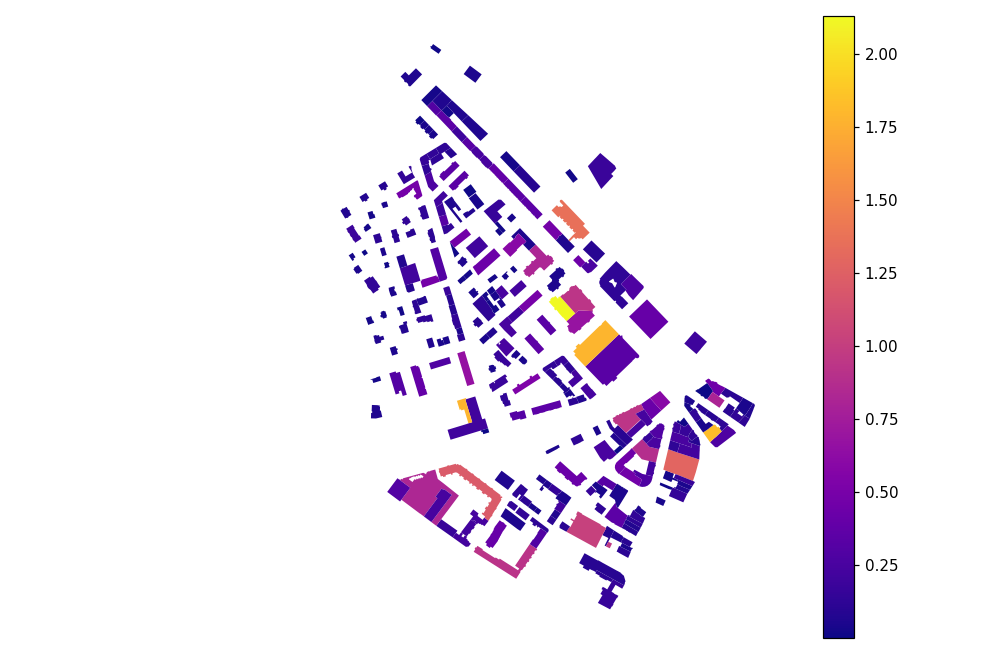

In [17]:
fig, ax = plt.subplots(figsize=(9, 6))
ax.axis("off")

gdf_to_plot = gdf.loc[:, ["Need_Heat", "Need_HW", "geometry"]]
gdf_to_plot["Need_Total"] = (gdf_to_plot.Need_Heat + gdf_to_plot.Need_HW)*1e-6

gdf_to_plot.loc[gdf.ID_Concept == 12].plot(ax=ax, column='Need_Total', cmap="plasma", legend=True)
plt.tight_layout()
plt.savefig(os.path.join("images", "d62a_total_needs.png"), dpi=150, bbox_inches="tight")

### Ignored EA

In [18]:
print("{:.1f}% of ignored hot water needs".format(100 - 100*(gdf.loc[gdf.EA_HW.isin(perf.AE)].Need_HW.sum() / gdf.Need_HW.sum())))

1.5% of ignored hot water needs


In [19]:
print("{:.1f}% of ignored heating needs".format(100 - 100*(gdf.loc[gdf.EA_Heat.isin(perf.AE)].Need_Heat.sum() / gdf.Need_Heat.sum())))

2.8% of ignored heating needs


## CAPEX

In [20]:
costs_folder = os.path.join("tools", "costs")
filepath = os.path.join(costs_folder, "capex_boiler.json")

with open(filepath) as json_file:
    boiler_costs = json.load(json_file)

In [21]:
def capex(p, ea):
    coef = {True: boiler_costs[ea]["sup"], False: boiler_costs[ea]["sup"]}[p > 100]
    return (coef[0]*p + coef[1])*boiler_costs[ea]["man"]

c_gas = gdf.loc[(gdf.ID_Concept == 12) & (gdf.EA_Heat == "gas"), "HeatPower"].map(lambda x: capex(x, "gas")).sum()*1e-3
c_oil = gdf.loc[(gdf.ID_Concept == 12) & (gdf.EA_Heat == "oil"), "HeatPower"].map(lambda x: capex(x, "oil")).sum()*1e-3
print("GAS: {:>4.1f} Mio CHF".format(c_gas))
print("OIL: {:>4.1f} Mio CHF".format(c_oil))
print("TOT: {:>4.1f} Mio CHF".format(c_gas+c_oil))

GAS:  5.5 Mio CHF
OIL:  4.1 Mio CHF
TOT:  9.6 Mio CHF


## OPEX

In [22]:
print("GAS: {:>4.1f} Mio CHF / year".format(stu_area.EF_GWh["gas"] * 0.16))  # Mio CHF / GWh = CHF / kWh
print("OIL: {:>4.1f} Mio CHF / year".format(stu_area.EF_GWh["oil"] * 0.18))  # Mio CHF / GWh = CHF / kWh
print("TOT: {:>4.1f} Mio CHF / year".format(stu_area.EF_GWh["gas"] * 0.16 + stu_area.EF_GWh["oil"] * 0.18))

GAS:  5.8 Mio CHF / year
OIL:  5.3 Mio CHF / year
TOT: 11.2 Mio CHF / year
